#Install Required Packages and Import Libraries

In [1]:
# Install required packages (run this cell once)
!pip install opencv-python numpy matplotlib --quiet

# Import necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display
import requests
from pathlib import Path

#Download Data From Kaggle

In [2]:
# Install Kaggle package
!pip install kaggle --quiet

# Upload your kaggle.json file (API token from Kaggle)
from google.colab import files
uploaded = files.upload()  # Select kaggle.json from your computer

Saving kaggle.json to kaggle.json
Kaggle API set up successfully.


In [8]:
import zipfile
import os
from pathlib import Path

# Path to the zip file
zip_path = "/content/face_dataset/face-detection-dataset.zip"

# Directory to extract to (will create if not exists)
extract_dir = "/content/face_dataset"

# Create extraction directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Check if zip file exists
if not os.path.exists(zip_path):
    print(f"Error: Zip file not found at {zip_path}")
    print("Available files in /content/face_dataset:")
    !ls /content/face_dataset
else:
    print(f"Found zip file: {zip_path}")
    print(f"File size: {os.path.getsize(zip_path) / (1024*1024):.2f} MB")

    # Unzip the file
    print("Extracting files... This may take a few minutes depending on size.")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        # Extract all contents
        zip_ref.extractall(extract_dir)

    print("Extraction completed successfully!")

    # Show the extracted structure
    print("\nExtracted folder structure:")
    !find /content/face_dataset -type d | head -20
    print("\nFirst few image files (if any):")
    !find /content/face_dataset -name "*.jpg" -o -name "*.jpeg" -o -name "*.png" | head -10

Dataset URL: https://www.kaggle.com/datasets/fareselmenshawii/face-detection-dataset
License(s): CC0-1.0
 99% 4.41G/4.43G [01:11<00:01, 19.4MB/s]
100% 4.43G/4.43G [01:11<00:00, 66.3MB/s]
Download and extraction completed!

Extracted folders:
images	labels	labels2

Subfolders in images (if exists):
train  val

First few image files:
/content/face_dataset/images/train/00006c07d2b033d1.jpg
/content/face_dataset/images/train/0000bee39176697a.jpg
/content/face_dataset/images/train/0000eda1171fe14e.jpg
/content/face_dataset/images/train/00090bdd55ec42c3.jpg
/content/face_dataset/images/train/000d1eae99343db8.jpg
/content/face_dataset/images/train/001065b2a612f5ad.jpg
/content/face_dataset/images/train/00134c19ee564cad.jpg
/content/face_dataset/images/train/00143d27992ccf33.jpg
/content/face_dataset/images/train/0014d30877173ab7.jpg
/content/face_dataset/images/train/0019f8ef73bbe608.jpg


#Test Model on Real Data from DataSet

Old deploy.prototxt deleted.
Old res10_300x300_ssd_iter_140000.caffemodel deleted.
Model files downloaded successfully.
Face detection model loaded successfully.
Found 13386 images. Selecting 5 random images for detection.
b9bda58ef7222512.jpg → Detected 0 face(s)
1748f9a9e3b500e1.jpg → Detected 4 face(s)
43774be717a7145a.jpg → Detected 1 face(s)
58cf1506e5da7977.jpg → Detected 2 face(s)
40ebbf62a87142f9.jpg → Detected 0 face(s)


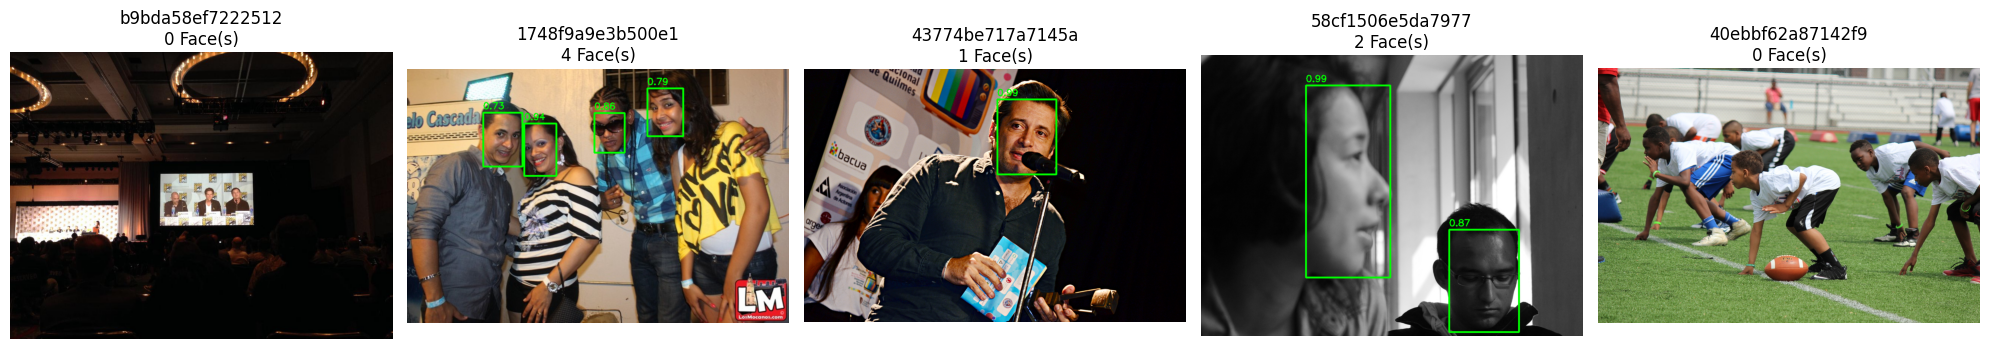

In [9]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import requests

# -----------------------------
# Delete old model files to avoid corruption issues
# -----------------------------
model_dir = Path("/content/model")
model_dir.mkdir(exist_ok=True)

prototxt_path = model_dir / "deploy.prototxt"
caffemodel_path = model_dir / "res10_300x300_ssd_iter_140000.caffemodel"

if prototxt_path.exists():
    prototxt_path.unlink()
    print("Old deploy.prototxt deleted.")

if caffemodel_path.exists():
    caffemodel_path.unlink()
    print("Old res10_300x300_ssd_iter_140000.caffemodel deleted.")

# -----------------------------
# Download model files with correct URLs
# -----------------------------
prototxt_url = "https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt"
caffemodel_url = "https://github.com/opencv/opencv_3rdparty/raw/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel"

print("Downloading deploy.prototxt...")
with open(prototxt_path, "wb") as f:
    f.write(requests.get(prototxt_url).content)

print("Downloading res10_300x300_ssd_iter_140000.caffemodel (10.7 MB - this may take 1-2 minutes)...")
with open(caffemodel_path, "wb") as f:
    f.write(requests.get(caffemodel_url).content)

print("Model files downloaded successfully.")

# -----------------------------
# Load the face detection model
# -----------------------------
def load_face_detection_model(prototxt_path, caffemodel_path):
    """
    Loads the pre-trained Caffe-based face detection model from OpenCV.

    Args:
        prototxt_path (Path): Path to the deploy.prototxt file.
        caffemodel_path (Path): Path to the pre-trained weights file.

    Returns:
        cv2.dnn_Net: Loaded neural network model.
    """
    net = cv2.dnn.readNetFromCaffe(str(prototxt_path), str(caffemodel_path))
    return net

face_net = load_face_detection_model(prototxt_path, caffemodel_path)
print("Face detection model loaded successfully.")

# -----------------------------
# Face detection function
# -----------------------------
def detect_faces(image, net, confidence_threshold=0.5):
    """
    Detects faces in the input image using the DNN model.

    Args:
        image (np.ndarray): Input image in BGR format.
        net (cv2.dnn_Net): Loaded face detection model.
        confidence_threshold (float): Minimum confidence to accept a detection.

    Returns:
        list: List of detected faces as (x1, y1, x2, y2, confidence).
    """
    (h, w) = image.shape[:2]

    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)),
                                 1.0, (300, 300), (104.0, 177.0, 123.0))

    net.setInput(blob)
    detections = net.forward()

    faces = []
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > confidence_threshold:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (x1, y1, x2, y2) = box.astype("int")
            faces.append((x1, y1, x2, y2, confidence))

    return faces

# -----------------------------
# Process images from dataset
# -----------------------------
images_dir = "/content/face_dataset/images/train"

if not os.path.exists(images_dir):
    print(f"Error: Directory not found: {images_dir}")
else:
    image_files = [f for f in os.listdir(images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    if len(image_files) == 0:
        print("No images found in the directory.")
    else:
        print(f"Found {len(image_files)} images. Selecting 5 random images for detection.")

        num_images = 5
        selected_images = random.sample(image_files, min(num_images, len(image_files)))

        fig, axs = plt.subplots(1, num_images, figsize=(20, 6))

        for i, img_file in enumerate(selected_images):
            img_path = os.path.join(images_dir, img_file)

            image = cv2.imread(img_path)
            if image is None:
                print(f"Failed to load: {img_path}")
                continue

            faces = detect_faces(image, face_net, confidence_threshold=0.5)
            print(f"{img_file} → Detected {len(faces)} face(s)")

            for (x1, y1, x2, y2, conf) in faces:
                cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 3)
                label = f"{conf:.2f}"
                cv2.putText(image, label, (x1, y1 - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

            axs[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            axs[i].set_title(f"{os.path.splitext(img_file)[0]}\n{len(faces)} Face(s)")
            axs[i].axis('off')

        plt.tight_layout()
        plt.show()